In [14]:
print("""
Full Name:    Frank Evin YAMI
student's ID: 0232112159

Modelling and Analysis of Complex Networks
Assignment : 10
Number of the dataset : 5
""")


Full Name:    Frank Evin YAMI
student's ID: 0232112159
      
Modelling and Analysis of Complex Networks
Assignment : 10 
Number of the dataset : 5



In [ ]:
#!pip install node2vec

In [23]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import urllib.request
from node2vec import Node2Vec
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, roc_curve


### Step 1: Load the Facebook-Ego dataset and create the graph

In [20]:

# Set random seed for reproducibility
random.seed(42)

#Load the Facebook-Ego dataset and create the graph

facebook_url = "https://raw.githubusercontent.com/1250326/exercise_complex_network/master/Datasets/Group5/Facebook-Ego/686.edges"

# Download the Facebook-Ego network file
urllib.request.urlretrieve(facebook_url, "facebook.edges")

# Load the Facebook-Ego network as an undirected graph
facebook_network = nx.read_edgelist("facebook.edges", nodetype=int)
num_nodes = facebook_network.number_of_nodes()
num_edges = facebook_network.number_of_edges()

print(f"Number of nodes: {num_nodes}, Number of edges: {num_edges}")


Number of nodes: 168, Number of edges: 1656


### Step 2: Split data into training and testing sets

In [21]:
num_test_edges = int(0.1 * num_edges)  # 10% of edges for testing
test_edges = random.sample(list(facebook_network.edges), num_test_edges)

# Create training graph
G_train = facebook_network.copy()
G_train.remove_edges_from(test_edges)
num_edges_train = G_train.number_of_edges()
print(f"Number of training edges: {num_edges_train}")

Number of training edges: 1491


In [24]:
# Generate all possible node pairs (non-edges) for negative sampling
all_possible_pairs = set(combinations(facebook_network.nodes, 2))
existing_edges = set(facebook_network.edges)
non_edges = list(all_possible_pairs - existing_edges)

# Sample an equal number of negative samples as the test edges
negative_samples = random.sample(non_edges, num_test_edges)

# Combine test edges (positive samples) and negative samples for the test set
test_set = pd.DataFrame(test_edges + negative_samples, columns=["node1", "node2"])
test_set["label"] = [1] * len(test_edges) + [0] * len(negative_samples)

### Step 3: Generate node embeddings using node2vec

In [25]:
node2vec = Node2Vec(G_train, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Function to extract embeddings for an edge
def edge_to_embedding(u, v, model):
    embedding_u = model.wv[str(u)]
    embedding_v = model.wv[str(v)]
    return np.concatenate((embedding_u, embedding_v))

Computing transition probabilities:   0%|          | 0/168 [00:00<?, ?it/s]

### Step 4: Prepare test set features using node2vec embeddings

In [26]:
test_set["embedding"] = test_set.apply(lambda row: edge_to_embedding(row["node1"], row["node2"], model), axis=1)

# Split into X (features) and y (labels)
X_test = np.array(test_set["embedding"].tolist())
y_test = test_set["label"]


### Step 5: Prepare training data

In [27]:
# Sample an equal number of positive and negative edges for training
train_positive_edges = random.sample(list(G_train.edges), num_test_edges)
train_negative_edges = random.sample(non_edges, num_test_edges)

train_set = pd.DataFrame(train_positive_edges + train_negative_edges, columns=["node1", "node2"])
train_set["label"] = [1] * len(train_positive_edges) + [0] * len(train_negative_edges)

# Generate embeddings for training edges
train_set["embedding"] = train_set.apply(lambda row: edge_to_embedding(row["node1"], row["node2"], model), axis=1)

X_train = np.array(train_set["embedding"].tolist())
y_train = train_set["label"]


### Step 6: Train a logistic regression classifier

In [28]:
clf = LogisticRegression()
clf.fit(X_train, y_train)


LogisticRegression()

### Step 7: Evaluate the model

In [29]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

### Step 8: Plot ROC curve

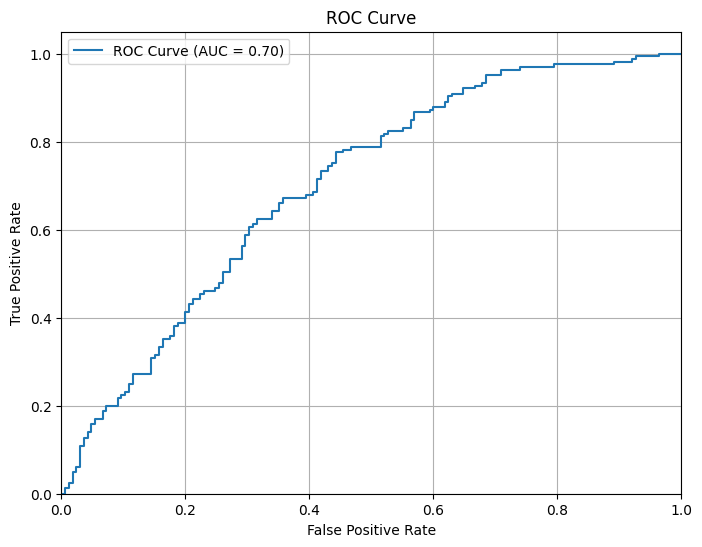

In [32]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [31]:
# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"AUROC: {roc_auc:.2f}")


Accuracy: 0.64
Precision: 0.62
AUROC: 0.70
